# Accessing the data through GEE

In [1]:
import geemap
import ee
import geemap
import numpy as np
import rioxarray as rxr
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import shutil

In [2]:
ee.Authenticate()

True

In [3]:
ee.Initialize()

In [4]:
Map=geemap.Map()
Map


Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

In [5]:
ROI=geemap.shp_to_ee(r'D:\PhD\GIS\DP\SHP_Nambia\Namibia_South.shp')
Map.addLayer(ROI, {}, 'ROI')

## NDVI & EVI

In [ ]:
modis = ee.ImageCollection("MODIS/061/MYD13Q1") \
    .filterBounds(ROI) \
    .filterDate("2020-01-01", "2025-01-31") \
    .map(lambda img: img.clip(ROI))

ndvi = modis.select("NDVI").map(lambda img: img.divide(10000).copyProperties(img, ["system:time_start"]))
evi = modis.select("EVI").map(lambda img: img.divide(10000).copyProperties(img, ["system:time_start"]))


### For NDVI

In [18]:
timestamps_ndvi = ndvi.aggregate_array("system:time_start").getInfo()
ids_ndvi = ndvi.aggregate_array("system:index").getInfo()

In [19]:
dates_ndvi = pd.to_datetime(timestamps_ndvi, unit="ms")
dates_ndvi

DatetimeIndex(['2020-01-09', '2020-01-25', '2020-02-10', '2020-02-26',
               '2020-03-13', '2020-03-29', '2020-04-14', '2020-04-30',
               '2020-05-16', '2020-06-01',
               ...
               '2024-09-05', '2024-09-21', '2024-10-07', '2024-10-23',
               '2024-11-08', '2024-11-24', '2024-12-10', '2024-12-26',
               '2025-01-09', '2025-01-25'],
              dtype='datetime64[ns]', length=117, freq=None)

In [20]:
ids_full_ndvi = [f"MODIS/061/MYD13Q1/{id.replace('.', '_')}" for id in ids_ndvi]


In [21]:
df = pd.DataFrame({
    "id": ids_full_ndvi,
    "date": dates_ndvi.strftime("%Y-%m-%d")
})

df.to_csv(r"D:/PhD/GIS/DP/NDVI/MYD13Q1_id_dates_ndvi.csv", index=False)

### For EVI

In [22]:
timestamps_evi = evi.aggregate_array("system:time_start").getInfo()
ids_evi = evi.aggregate_array("system:index").getInfo()

In [23]:
dates_evi = pd.to_datetime(timestamps_evi, unit="ms")
dates_evi

DatetimeIndex(['2020-01-09', '2020-01-25', '2020-02-10', '2020-02-26',
               '2020-03-13', '2020-03-29', '2020-04-14', '2020-04-30',
               '2020-05-16', '2020-06-01',
               ...
               '2024-09-05', '2024-09-21', '2024-10-07', '2024-10-23',
               '2024-11-08', '2024-11-24', '2024-12-10', '2024-12-26',
               '2025-01-09', '2025-01-25'],
              dtype='datetime64[ns]', length=117, freq=None)

In [24]:
ids_full_evi = [f"MODIS/061/MYD13Q1/{id.replace('.', '_')}" for id in ids_evi]


In [25]:
df_evi = pd.DataFrame({
    "id": ids_full_evi,
    "date": dates_evi.strftime("%Y-%m-%d")
})

df_evi.to_csv(r"D:/PhD/GIS/DP/NDVI/MYD13Q1_id_dates_evi.csv", index=False)

## Visualization and Downloading

In [26]:
vis_params = {
    'min': 0.0,
    'max': 1.0,
    'palette': [
        'FFFFFF',
        'CE7E45',
        'DF923D',
        'F1B555',
        'FCD163',
        '99B718',
        '74A901',
        '66A000',
        '529400',
        '3E8601',
        '207401',
        '056201',
        '004C00',
        '023B01',
        '012E01',
        '011D01',
        '011301',
    ],
}

first_ndvi_image = ndvi.first()
first_evi_image = evi.first()


In [27]:
Map.addLayer(first_ndvi_image, vis_params, "First NDVI image")
Map.addLayer(first_evi_image, vis_params, "First EVI image")


In [28]:
def to_stacked_image(ic, band_name):
    image_list = ic.toList(ic.size())
    stacked = ee.Image(image_list.get(0)).select([band_name]).rename(f"{band_name}_001")
    
    for i in range(1, ic.size().getInfo()):
        img = ee.Image(image_list.get(i)).select([band_name])
        stacked = stacked.addBands(img.rename(f"{band_name}_{i+1:03d}"))
    return stacked

In [29]:
ndvi_stack = to_stacked_image(ndvi, "NDVI")
evi_stack = to_stacked_image(evi, "EVI")

In [30]:
evi_stack

In [31]:
ndvi_stack

In [32]:
task = ee.batch.Export.image.toDrive(
    image=ndvi_stack,
    description='NDVI_stack_export',
    folder='DP_Namibia',
    fileNamePrefix='ndvi_stack',
    region=ROI.geometry(),
    scale=250,
    maxPixels=1e13,
    fileFormat='GeoTIFF',
    crs='EPSG:4326'

)
task.start()
task.status()


{'state': 'READY',
 'description': 'NDVI_stack_export',
 'priority': 100,
 'creation_timestamp_ms': 1753441351059,
 'update_timestamp_ms': 1753441351059,
 'start_timestamp_ms': 0,
 'task_type': 'EXPORT_IMAGE',
 'id': 'AY3T6LONFGCNGER76AMQANIS',
 'name': 'projects/585955493689/operations/AY3T6LONFGCNGER76AMQANIS'}

In [33]:
tasks = ee.batch.Task.list()
for t in tasks:
    print(t.status())

{'state': 'READY', 'description': 'NDVI_stack_export', 'priority': 100, 'creation_timestamp_ms': 1753441351059, 'update_timestamp_ms': 1753441351059, 'start_timestamp_ms': 0, 'task_type': 'EXPORT_IMAGE', 'id': 'AY3T6LONFGCNGER76AMQANIS', 'name': 'projects/585955493689/operations/AY3T6LONFGCNGER76AMQANIS'}
{'state': 'COMPLETED', 'description': 'evi_stack_export', 'priority': 100, 'creation_timestamp_ms': 1753358806793, 'update_timestamp_ms': 1753359888721, 'start_timestamp_ms': 1753358816406, 'task_type': 'EXPORT_IMAGE', 'destination_uris': ['https://drive.google.com/#folders/1jkUsinVsfsGK7hrOQ9XcWUSSFmFRnOEt'], 'attempt': 1, 'batch_eecu_usage_seconds': 895.905029296875, 'id': 'STBJFWTH7BB6QKF5BDMCA5RJ', 'name': 'projects/585955493689/operations/STBJFWTH7BB6QKF5BDMCA5RJ'}
{'state': 'COMPLETED', 'description': 'evi_stack_export', 'priority': 100, 'creation_timestamp_ms': 1753357591375, 'update_timestamp_ms': 1753358098579, 'start_timestamp_ms': 1753357601107, 'task_type': 'EXPORT_IMAGE',

In [34]:
task_evi = ee.batch.Export.image.toDrive(
    image=evi_stack,
    description='evi_stack_export',
    folder='DP_Namibia',
    fileNamePrefix='evi_stack',
    region=ROI.geometry(),
    scale=250,
    maxPixels=1e13,
    fileFormat='GeoTIFF',
    crs='EPSG:4326'
)
task_evi.start()

In [36]:
tasks = ee.batch.Task.list()
for t in tasks:
    print(t.status())

{'state': 'RUNNING', 'description': 'evi_stack_export', 'priority': 100, 'creation_timestamp_ms': 1753441357932, 'update_timestamp_ms': 1753441843694, 'start_timestamp_ms': 1753441367566, 'task_type': 'EXPORT_IMAGE', 'attempt': 1, 'batch_eecu_usage_seconds': 844.038, 'id': 'OTXQOMPWNYGC63XOQ4MPNECA', 'name': 'projects/585955493689/operations/OTXQOMPWNYGC63XOQ4MPNECA'}
{'state': 'RUNNING', 'description': 'NDVI_stack_export', 'priority': 100, 'creation_timestamp_ms': 1753441351059, 'update_timestamp_ms': 1753441803870, 'start_timestamp_ms': 1753441361746, 'task_type': 'EXPORT_IMAGE', 'attempt': 1, 'batch_eecu_usage_seconds': 902.648, 'id': 'AY3T6LONFGCNGER76AMQANIS', 'name': 'projects/585955493689/operations/AY3T6LONFGCNGER76AMQANIS'}
{'state': 'COMPLETED', 'description': 'evi_stack_export', 'priority': 100, 'creation_timestamp_ms': 1753358806793, 'update_timestamp_ms': 1753359888721, 'start_timestamp_ms': 1753358816406, 'task_type': 'EXPORT_IMAGE', 'destination_uris': ['https://drive.go

## Reading NDVI and EVI

In [2]:
ndvi_path=r'D:\PhD\GIS\DP\NDVI\ndvi_stack.tif'
evi_path=r'D:\PhD\GIS\DP\NDVI\evi_stack.tif'
date_csv_path=r'D:\PhD\GIS\DP\NDVI\MYD13Q1_id_dates_ndvi.csv'

In [3]:
ndvi_xarray  = rxr.open_rasterio(ndvi_path, masked=True)  # shape: [band, y, x]
evi_xarray  = rxr.open_rasterio(evi_path, masked=True)  # shape: [band, y, x]
date_csv= pd.read_csv(date_csv_path)
date=date_csv['date'].values
date= pd.to_datetime(date)
date

DatetimeIndex(['2020-01-09', '2020-01-25', '2020-02-10', '2020-02-26',
               '2020-03-13', '2020-03-29', '2020-04-14', '2020-04-30',
               '2020-05-16', '2020-06-01',
               ...
               '2024-09-05', '2024-09-21', '2024-10-07', '2024-10-23',
               '2024-11-08', '2024-11-24', '2024-12-10', '2024-12-26',
               '2025-01-09', '2025-01-25'],
              dtype='datetime64[ns]', length=117, freq=None)

In [4]:
ndvi_xarray

<xarray.DataArray (band: 117, y: 2580, x: 2471)> Size: 3GB
[745896060 values with dtype=float32]
Coordinates:
  * band         (band) int32 468B 1 2 3 4 5 6 7 ... 111 112 113 114 115 116 117
  * x            (x) float64 20kB 14.45 14.46 14.46 14.46 ... 20.0 20.0 20.0
  * y            (y) float64 21kB -23.17 -23.17 -23.17 ... -28.95 -28.96 -28.96
    spatial_ref  int32 4B 0
Attributes:
    AREA_OR_POINT:             Area
    STATISTICS_APPROXIMATE:    YES
    STATISTICS_MAXIMUM:        0.81809997558594
    STATISTICS_MEAN:           0.12392508214376
    STATISTICS_MINIMUM:        -0.14769999682903
    STATISTICS_STDDEV:         0.032893339791032
    STATISTICS_VALID_PERCENT:  79.83
    scale_factor:              1.0
    add_offset:                0.0
    long_name:                 ('NDVI_001', 'NDVI_002', 'NDVI_003', 'NDVI_004...

In [5]:
ndvi_xarray=ndvi_xarray.assign_coords(time=('band',date))
evi_xarray=evi_xarray.assign_coords(time=('band',date))

In [6]:
# Remove the 'time' coordinate temporarily
ndvi_xarray = ndvi_xarray.drop_vars("time")

# Reassign correct datetime values as coordinate and dimension
ndvi_xarray = ndvi_xarray.rename(band="time")
ndvi_xarray = ndvi_xarray.assign_coords(time=date)

# Repeat for EVI if needed
evi_xarray = evi_xarray.drop_vars("time")
evi_xarray = evi_xarray.rename(band="time")
evi_xarray = evi_xarray.assign_coords(time=date)

In [7]:
ndvi_xarray

<xarray.DataArray (time: 117, y: 2580, x: 2471)> Size: 3GB
[745896060 values with dtype=float32]
Coordinates:
  * x            (x) float64 20kB 14.45 14.46 14.46 14.46 ... 20.0 20.0 20.0
  * y            (y) float64 21kB -23.17 -23.17 -23.17 ... -28.95 -28.96 -28.96
    spatial_ref  int32 4B 0
  * time         (time) datetime64[ns] 936B 2020-01-09 2020-01-25 ... 2025-01-25
Attributes:
    AREA_OR_POINT:             Area
    STATISTICS_APPROXIMATE:    YES
    STATISTICS_MAXIMUM:        0.81809997558594
    STATISTICS_MEAN:           0.12392508214376
    STATISTICS_MINIMUM:        -0.14769999682903
    STATISTICS_STDDEV:         0.032893339791032
    STATISTICS_VALID_PERCENT:  79.83
    scale_factor:              1.0
    add_offset:                0.0
    long_name:                 ('NDVI_001', 'NDVI_002', 'NDVI_003', 'NDVI_004...

In [8]:
evi_xarray

<xarray.DataArray (time: 117, y: 2580, x: 2471)> Size: 3GB
[745896060 values with dtype=float32]
Coordinates:
  * x            (x) float64 20kB 14.45 14.46 14.46 14.46 ... 20.0 20.0 20.0
  * y            (y) float64 21kB -23.17 -23.17 -23.17 ... -28.95 -28.96 -28.96
    spatial_ref  int32 4B 0
  * time         (time) datetime64[ns] 936B 2020-01-09 2020-01-25 ... 2025-01-25
Attributes:
    AREA_OR_POINT:             Area
    STATISTICS_APPROXIMATE:    YES
    STATISTICS_MAXIMUM:        0.99849998950958
    STATISTICS_MEAN:           0.076769260312348
    STATISTICS_MINIMUM:        -0.059900000691414
    STATISTICS_STDDEV:         0.020088499158434
    STATISTICS_VALID_PERCENT:  79.83
    scale_factor:              1.0
    add_offset:                0.0
    long_name:                 ('EVI_001', 'EVI_002', 'EVI_003', 'EVI_004', '...

In [9]:
ndvi_mean=ndvi_xarray.mean(dim=["y", "x"]).values
evi_mean=evi_xarray.mean(dim=["y", "x"]).values

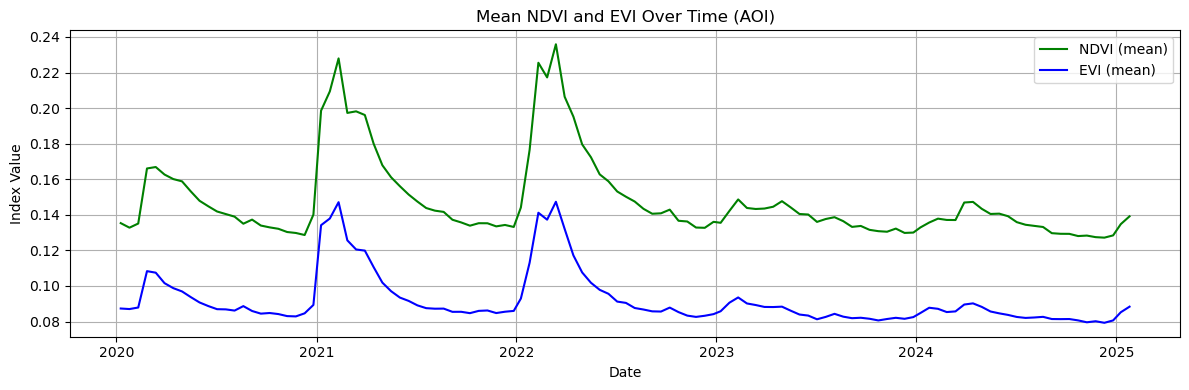

In [10]:
plt.figure(figsize=(12, 4))
plt.plot(ndvi_xarray.time, ndvi_mean, label="NDVI (mean)", color="green")
plt.plot(evi_xarray.time, evi_mean, label="EVI (mean)", color="blue")
plt.title("Mean NDVI and EVI Over Time (AOI)")
plt.xlabel("Date")
plt.ylabel("Index Value")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

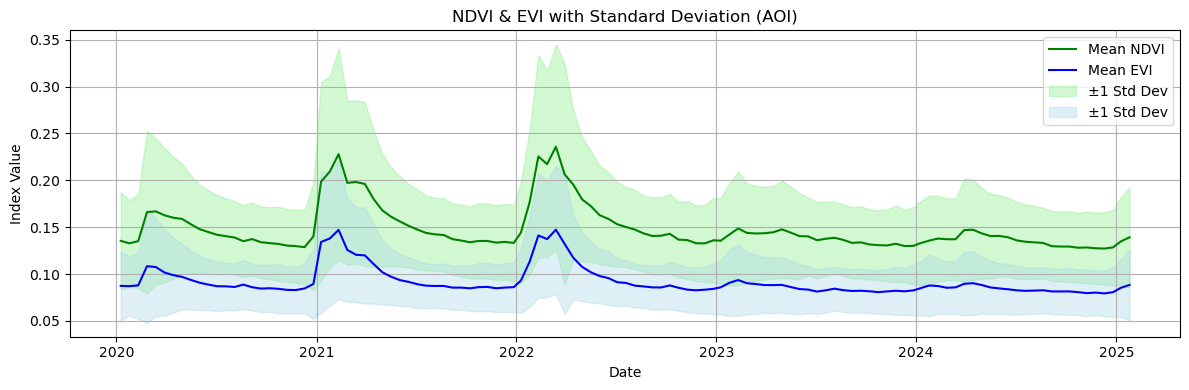

In [11]:
ndvi_std = ndvi_xarray.std(dim=["x", "y"])
evi_std=evi_xarray.std(dim=["x", "y"])
plt.figure(figsize=(12, 4))
plt.plot(ndvi_xarray.time, ndvi_mean, label="Mean NDVI", color="green")
plt.plot(evi_xarray.time, evi_mean, label="Mean EVI", color="blue")
plt.fill_between(ndvi_xarray.time.values,
                 ndvi_mean - ndvi_std,
                 ndvi_mean + ndvi_std,
                 color="lightgreen", alpha=0.4,
                 label="±1 Std Dev")
plt.fill_between(evi_xarray.time.values,
                 evi_mean - evi_std,evi_mean + evi_std,
                 color="lightblue", alpha=0.4,
                    label="±1 Std Dev")
plt.title("NDVI & EVI with Standard Deviation (AOI)")
plt.xlabel("Date")
plt.ylabel("Index Value")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

## Monthly NDVI and EVI

In [22]:
ndvi_monthly_mean =  ndvi_xarray.mean(dim=["x", "y"]).resample(time="1MS").mean()

In [23]:
ndvi_monthly_mean

<xarray.DataArray (time: 61)> Size: 488B
array([0.13433906, 0.15096164, 0.16519165, 0.15978497, 0.15340184,
       0.14655447, 0.14133593, 0.13717744, 0.13582876, 0.13275433,
       0.13027634, 0.13460237, 0.2045494 , 0.21316501, 0.19757846,
       0.1804167 , 0.16478334, 0.15397267, 0.14585587, 0.14220378,
       0.13668951, 0.13480085, 0.13458502, 0.13394347, 0.16052756,
       0.22192422, 0.22155842, 0.19559813, 0.17630237, 0.16105194,
       0.15187457, 0.14562628, 0.14094348, 0.14001912, 0.13478869,
       0.13460235, 0.13914081, 0.1465874 , 0.14368972, 0.14484112,
       0.1462203 , 0.14057189, 0.13706011, 0.13772056, 0.13364249,
       0.13135764, 0.13159056, 0.13013932, 0.13451435, 0.13772194,
       0.14221963, 0.14553767, 0.14069937, 0.14012843, 0.13534415,
       0.13366039, 0.12970385, 0.12887481, 0.12809685, 0.12801743,
       0.1372821 ])
Coordinates:
    spatial_ref  int32 4B 0
  * time         (time) datetime64[ns] 488B 2020-01-01 2020-02-01 ... 2025-01-01

## Precipitation using CHIRPS

In [10]:
shutil.unpack_archive(r'D:\PhD\GIS\DP\Precip\chirps_zarr.zip', r'D:\PhD\GIS\DP\Precip\zarr_file')

In [4]:
dataset = xr.open_zarr(r"D:\PhD\GIS\DP\Precip\zarr_file")
chirps_2020_2025=dataset.sel(time=slice("2020-01-01", "2025-01-31"))
chirps_2020_2025.precipitation


<xarray.DataArray 'precipitation' (time: 1736, y: 54, x: 111)> Size: 83MB
dask.array<getitem, shape=(1736, 54, 111), dtype=float64, chunksize=(1736, 7, 28), chunktype=numpy.ndarray>
Coordinates:
  * y        (y) float64 432B -23.18 -23.23 -23.28 ... -25.73 -25.78 -25.83
  * x        (x) float64 888B 14.48 14.53 14.58 14.63 ... 19.88 19.93 19.98
  * time     (time) datetime64[ns] 14kB 2020-01-01 2020-01-02 ... 2025-01-31
Attributes:
    TIFFTAG_DOCUMENTNAME:      /home/sandbox/chirps/v2.0/daily_downscaled_by_...
    TIFFTAG_IMAGEDESCRIPTION:  IDL TIFF file
    TIFFTAG_SOFTWARE:          IDL 8.5, Exelis Visual Information Solutions, ...
    TIFFTAG_DATETIME:          2015:09:01 17:10:36
    TIFFTAG_XRESOLUTION:       100
    TIFFTAG_YRESOLUTION:       100
    TIFFTAG_RESOLUTIONUNIT:    2 (pixels/inch)
    OVR_RESAMPLING_ALG:        NEAREST
    AREA_OR_POINT:             Area
    grid_mapping:              spatial_ref

In [43]:
precip = chirps_2020_2025.precipitation.mean(dim=["x", "y"])
precipipation_mean=precip.where(precip >=0)

In [44]:
precipipation_mean

<xarray.DataArray 'precipitation' (time: 1736)> Size: 14kB
dask.array<where, shape=(1736,), dtype=float64, chunksize=(1736,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 14kB 2020-01-01 2020-01-02 ... 2025-01-31

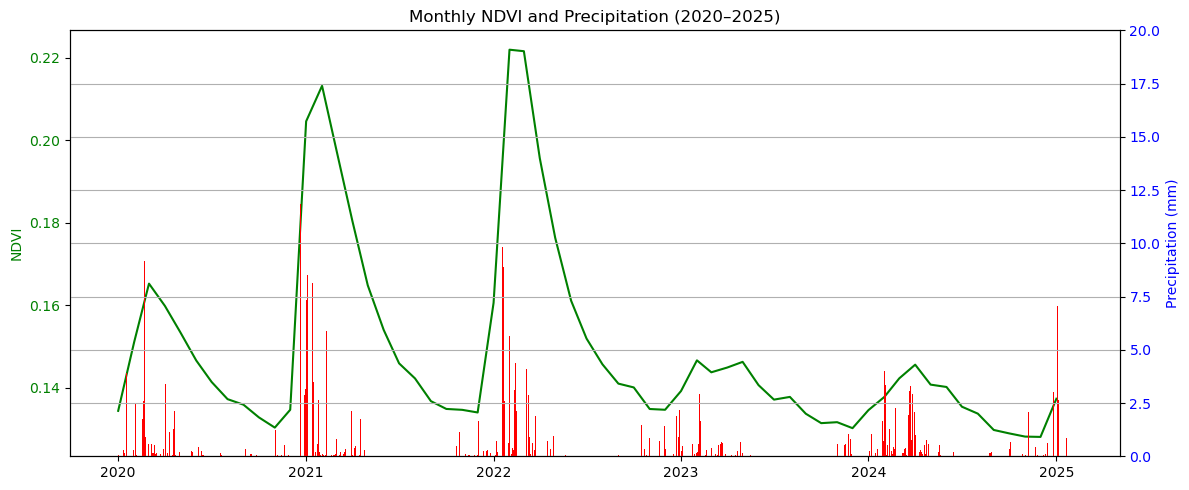

In [47]:
# Plot
fig, ax1 = plt.subplots(figsize=(12, 5))

# NDVI line (left y-axis)
ax1.plot(ndvi_monthly_mean.time.values,
         ndvi_monthly_mean.values,
         color="green", label="NDVI")
ax1.set_ylabel("NDVI", color="green")
ax1.tick_params(axis="y", labelcolor="green")

# Precipitation bars (right y-axis)
ax2 = ax1.twinx()
ax2.bar(precipipation_mean.time.values,
        precipipation_mean.values, color="RED", label="Precipitation")
ax2.set_ylabel("Precipitation (mm)", color="blue")
ax2.tick_params(axis="y", labelcolor="blue")
ax2.set_ylim(0, 20)

# Title and layout
plt.title("Monthly NDVI and Precipitation (2020–2025)")
plt.grid(True)
fig.tight_layout()
plt.show()